In [1]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np
from ta import add_all_ta_features

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Binary Classification Specific Metrics
#from sklearn.metrics import plot_roc_curve

# General Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import statsmodels.graphics.tsaplots as sgt
# Reporting
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree
from statsmodels.tsa.stattools import acf
from ta.trend import MACD


### Data Management

In [2]:
# Data Extraction
symbol = "LT.NS"

df = pd.read_csv("./stock_historical_data/{}.csv".format(symbol))
df.set_index("Date", inplace=True)

df = df[["Open", "High", "Low", "Close","Volume"]]
df["Returns"] = df["Close"].pct_change()
df["Range"] = df["High"] / df["Low"] - 1
df["Avg_Range"] = df["Range"].rolling(window=30).mean()
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Avg_Range
Date,,,,,,,,
2023-07-12,2480.300049,2485.949951,2451.100098,2472.500000,1081811,-0.000667,0.014218,0.014104
2023-07-12,2480.300049,2485.949951,2451.100098,2454.649902,1320558,-0.007219,0.014218,0.014214
2023-07-12,2480.300049,2485.949951,2451.100098,2455.649902,1439041,0.000407,0.014218,0.014388
2023-07-13,2466.000000,2484.899902,2446.250000,2450.149902,1141414,-0.002240,0.015800,0.014535
2023-07-14,2450.250000,2477.050049,2448.649902,2472.250000,845437,0.009020,0.011598,0.014434


In [3]:
#adding nifty index
dfNifty = pd.read_csv("./stock_historical_data/{}.csv".format("^NSEI"))
dfNifty.set_index("Date", inplace=True)


In [5]:
df = add_all_ta_features(df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
df = df.dropna()
df.head()

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


,Open,High,Low,Close,Volume,Returns,Range,Avg_Range,volume_adi,volume_obv,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2005-02-15,88.210306,90.852489,86.463479,88.065468,4917447,0.001847,0.050761,0.033646,-2.920726e+06,12723759,...,1.245320,0.762783,0.482536,-0.144647,-2.259098,2.114451,84.437152,0.184731,0.184560,2.707811
2005-02-16,88.662377,90.299481,88.315645,88.930107,2766033,0.009818,0.022463,0.033244,-3.973289e+06,15489792,...,1.374610,0.885149,0.489462,-0.600870,-1.927453,1.326583,84.852261,0.981814,0.977026,3.716211
2005-02-17,88.657990,89.974691,87.889914,89.592850,3490200,0.007452,0.023720,0.033451,-1.761597e+06,18979992,...,1.519757,1.012070,0.507687,1.007361,-1.340490,2.347851,85.252210,0.745240,0.742477,4.489146
2005-02-18,89.974697,90.984170,89.382181,89.996643,2147148,0.004507,0.017923,0.032387,-2.261616e+06,21127140,...,1.651527,1.139962,0.511565,-1.386383,-1.349668,-0.036714,85.702805,0.450698,0.449686,4.960076
2005-02-21,88.745771,90.764711,88.657989,89.513847,1631817,-0.005365,0.023762,0.032343,-2.567578e+06,19495323,...,1.690725,1.250114,0.440611,-4.832844,-2.046304,-2.786541,86.253751,-0.536460,-0.537904,4.397008


In [6]:
# Specify Target
df.loc[df["Close"].shift(-1) > df["Close"], "TARGET"] = 1
df.loc[df["Close"].shift(-1) <= df["Close"], "TARGET"] = 0

/var/folders/4_/_fbkdkz531s_92lxx_c_x6n00000gn/T/ipykernel_1639/3055005805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df["Close"].shift(-1) > df["Close"], "TARGET"] = 1


In [7]:
# Fill NA
df["TARGET"].fillna(0, inplace=True)
df.tail()

/var/folders/4_/_fbkdkz531s_92lxx_c_x6n00000gn/T/ipykernel_1639/3458268455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["TARGET"].fillna(0, inplace=True)


,Open,High,Low,Close,Volume,Returns,Range,Avg_Range,volume_adi,volume_obv,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,TARGET
Date,,,,,,,,,,,,,,,,,,,,,
2023-07-12,2480.300049,2485.949951,2451.100098,2472.500000,1081811,-0.000667,0.014218,0.014104,-3.908203e+08,659030014,...,1.830686,-0.008634,-12.166515,-10.712631,-1.453885,2431.607760,-0.066686,-0.066708,2783.594100,0.0
2023-07-12,2480.300049,2485.949951,2451.100098,2454.649902,1320558,-0.007219,0.014218,0.014214,-3.918718e+08,657709456,...,1.808396,-0.089158,-11.545000,-10.879104,-0.665896,2432.784941,-0.721945,-0.724564,2762.776128,1.0
2023-07-12,2480.300049,2485.949951,2451.100098,2455.649902,1439041,0.000407,0.014218,0.014388,-3.929351e+08,659148497,...,1.771165,-0.148928,-10.246010,-10.752486,0.506476,2433.224023,0.040739,0.040731,2763.942394,0.0
2023-07-13,2466.000000,2484.899902,2446.250000,2450.149902,1141414,-0.002240,0.015800,0.014535,-3.938462e+08,658007083,...,1.718873,-0.209165,-10.839266,-10.769842,-0.069424,2433.334044,-0.223973,-0.224224,2757.527928,1.0
2023-07-14,2450.250000,2477.050049,2448.649902,2472.250000,845437,0.009020,0.011598,0.014434,-3.932865e+08,658852520,...,1.670364,-0.194037,-13.034355,-11.222744,-1.811611,2433.751978,0.901990,0.897946,2783.302533,0.0


### Train Test Split

In [8]:
# Split into X and Y Data
X = df.iloc[:, : -1]
y = df.iloc[:, -1]

In [9]:
# Perform Train Test Split (Timeseries based method)
train_size_rate = 0.7
train_size = int(len(X) * train_size_rate)
test_size = len(X) - train_size

X_train = X.head(train_size)
y_train = y.head(train_size)
X_test = X.tail(test_size)
y_test = y.tail(test_size)

size_check = len(y_test) + len(y_train) == len(X)
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)
print("Size Matches: ", size_check)

Shape of X_train:  (3183, 94)
Shape of y_train:  (3183,)
Shape of X_test:  (1365, 94)
Shape of y_test:  (1365,)
Size Matches:  True


### Build Model

In [10]:
# Select type of model to optimize for
is_binary = True
is_optimise_for_precision = True

In [11]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [12]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [13]:
# Hyperparams: ne: 80, lr: 0.01 md: 3 gm: 6
# ne: 1#15, lr: 0.2 md: 5 gm: 20
#Recommended Params >> ne: 65, lr: 0.05 md: 1 gm: 20

ne = 65
lr = 0.05
md = 1
gm = 20

In [14]:
# XGBOOST Classifier
classifier = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [15]:
# Fit Model
eval_set = [(X_train, y_train), (X_test, y_test)]
classifier.set_params(eval_metric=eval_metric_list)  # Example metric: 'error'

classifier.fit(X_train, y_train, eval_set=eval_set, verbose=False)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=['error', 'logloss', 'logloss'], feature_types=None,
              gamma=20, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=65, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

### Make Predictions

In [16]:
# Get Predictions Training
train_yhat = classifier.predict(X_train)
train_yhat_proba = classifier.predict_proba(X_train)
print("Preds Training Data: \n", train_yhat[:10])
print("Preds Probabilities Training Data: \n", train_yhat_proba[:3])

Preds Training Data: 
 [1 1 1 1 1 1 1 0 1 1]
Preds Probabilities Training Data: 
 [[0.496081 0.503919]
 [0.496081 0.503919]
 [0.496081 0.503919]]


In [17]:
# Get Predictions Test
test_yhat = classifier.predict(X_test)
test_yhat_proba = classifier.predict_proba(X_test)
print("Preds Test Data: \n", test_yhat[:10])
print("Preds Probabilities Training Data: \n", test_yhat_proba[:3])

Preds Test Data: 
 [1 0 0 0 0 0 0 1 0 0]
Preds Probabilities Training Data: 
 [[0.49601597 0.50398403]
 [0.50136375 0.49863628]
 [0.50136375 0.49863628]]


In [18]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [19]:
# Training Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-def

### Evaluation Metrics  - Loss and Overfitting

In [20]:
# Retrieve performance metrics
results = classifier.evals_result()
epochs = len(results["validation_0"]["error"])
x_axis = range(0, epochs)

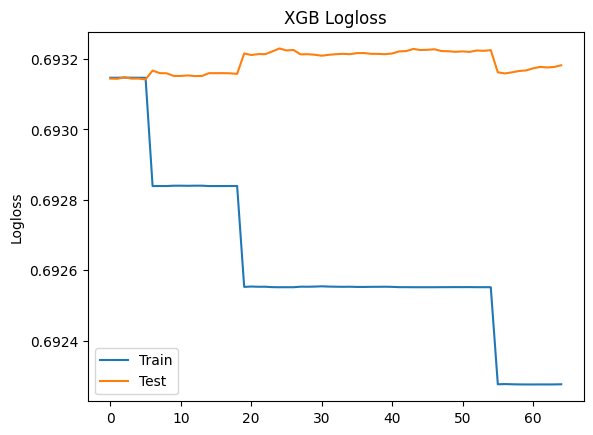

In [21]:
# Plot Log Loss
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["logloss"], label="Train")
ax.plot(x_axis, results["validation_1"]["logloss"], label="Test")
ax.legend()
plt.ylabel("Logloss")
plt.title("XGB Logloss")
plt.show()

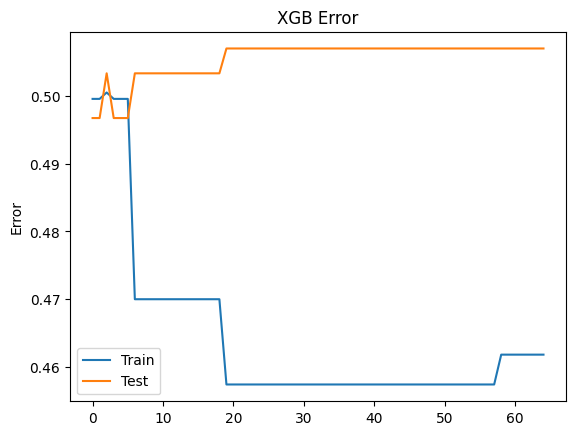

In [22]:
# Plot Classification Error
fig, ax = plt.subplots()
ax.plot(x_axis, results["validation_0"]["error"], label="Train")
ax.plot(x_axis, results["validation_1"]["error"], label="Test")
ax.legend()
plt.ylabel("Error")
plt.title("XGB Error")
plt.show()

### Evaluation Metrics - ROC Curve

In [22]:
# Plot Training ROC Curve
#plot_roc_curve(classifier, X_train, y_train)

In [23]:
# Plot Test ROC Curve
#plot_roc_curve(classifier, X_test, y_test)

### Performance Evaluation Comparison

In [23]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

In [24]:
# Training and Test Results
train_results = cross_val_score(classifier, X_train, y_train, scoring=scoring, cv=cv, n_jobs=-1)
test_results = cross_val_score(classifier, X_test, y_test, scoring=scoring, cv=cv, n_jobs=-1)

/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/vipin/opt/anaconda3/envs/my_own/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [25]:
# Comparison of Results
print("TRAIN:")
print("Average Acc K-Fold", round(train_results.mean(), 2))
print("Std Dev K-Fold", round(train_results.std(), 2))
print("Precision Score 0", round(precision_score(y_train, train_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_train, train_yhat, average=None)[1], 3))
print("----- ----- ----- ----- ----- ----- -----")
print("TEST:")
print("Average Acc K-Fold", round(test_results.mean(), 2))
print("Std Dev K-Fold", round(test_results.std(), 2))
print("Precision Score 0", round(precision_score(y_test, test_yhat, average=None)[0], 3))
print("Precision Score 1", round(precision_score(y_test, test_yhat, average=None)[1], 3))
print("")

TRAIN:
Average Acc K-Fold 0.4
Std Dev K-Fold 0.2
Precision Score 0 0.528
Precision Score 1 0.557
----- ----- ----- ----- ----- ----- -----
TEST:
Average Acc K-Fold 0.5
Std Dev K-Fold 0.0
Precision Score 0 0.494
Precision Score 1 0.489



### Evaluation Metrics - Summary Report

In [26]:
# Show summary report - Training
print(classification_report(y_train, train_yhat))

              precision    recall  f1-score   support

         0.0       0.53      0.70      0.60      1590
         1.0       0.56      0.38      0.45      1593

    accuracy                           0.54      3183
   macro avg       0.54      0.54      0.53      3183
weighted avg       0.54      0.54      0.53      3183



In [27]:
# Show summary report - Test
print(classification_report(y_test, test_yhat))

              precision    recall  f1-score   support

         0.0       0.49      0.83      0.62       678
         1.0       0.49      0.16      0.24       687

    accuracy                           0.49      1365
   macro avg       0.49      0.50      0.43      1365
weighted avg       0.49      0.49      0.43      1365



### Performance Evaluation - Confusion Matrix

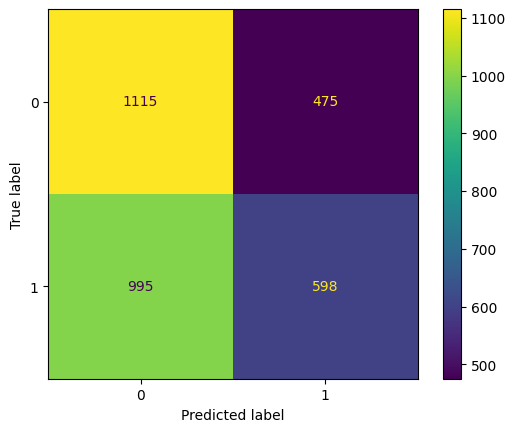

In [28]:
# Training Confusion Matrix
cm_train = confusion_matrix(y_train, train_yhat)
ConfusionMatrixDisplay(cm_train).plot()

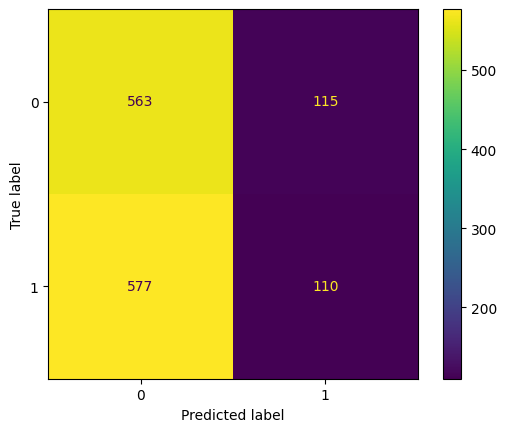

In [29]:
# Test Confusion Matrix
cm_test = confusion_matrix(y_test, test_yhat)
ConfusionMatrixDisplay(cm_test).plot()

### Feature Importance

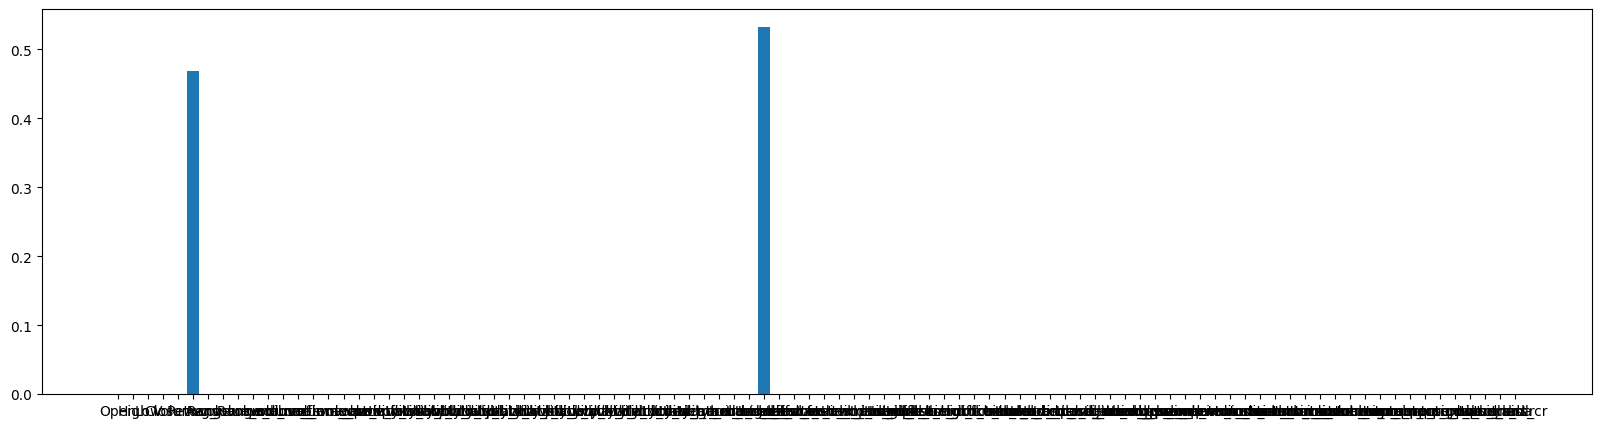

In [30]:
# Plot Feature Importances
fig = plt.figure(figsize=(20, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_

plt.bar(importance_labels, importance_features)
plt.show()

In [31]:
filtered_numbers = []
filterd_labels = []
filter_score = []
for index,ddd in enumerate(importance_features):
    if ddd > 0.05:
        filter_score.append(ddd)
        filterd_labels.append(importance_labels[index])
       # print(importance_labels[index])
print(filterd_labels)

['Returns', 'trend_sma_slow']


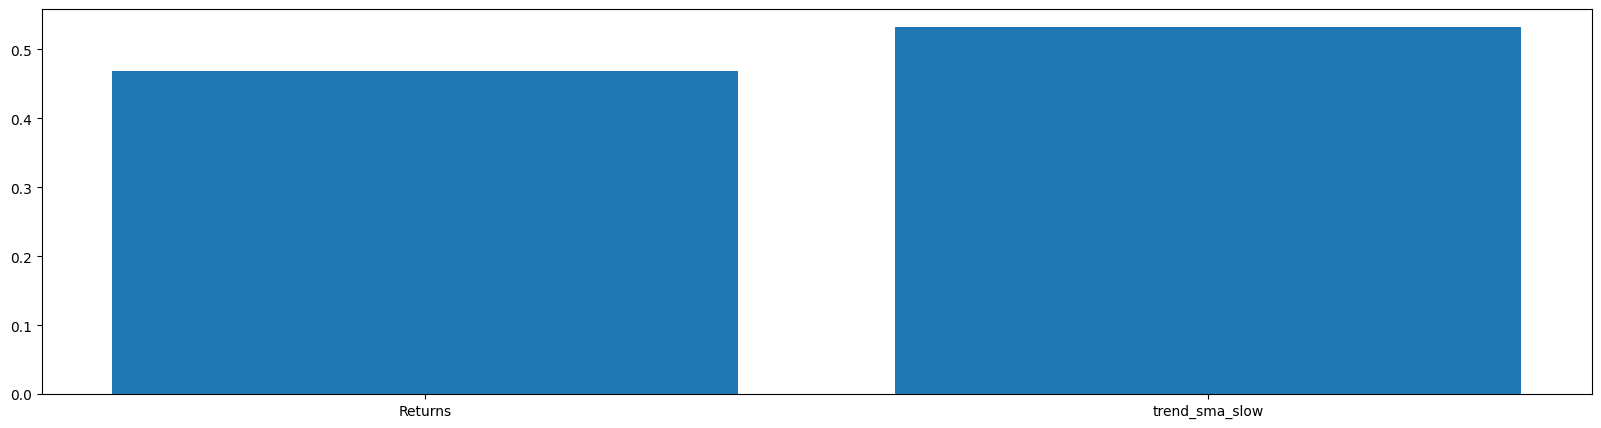

In [32]:
# Plot Feature Importances
fig = plt.figure(figsize=(20, 5))
importance_labels = X.columns
importance_features = classifier.feature_importances_

plt.bar(filterd_labels, filter_score)
plt.show()

In [32]:
#conda install graphviz python-graphviz

### XGBOOST TREE

<Axes: >

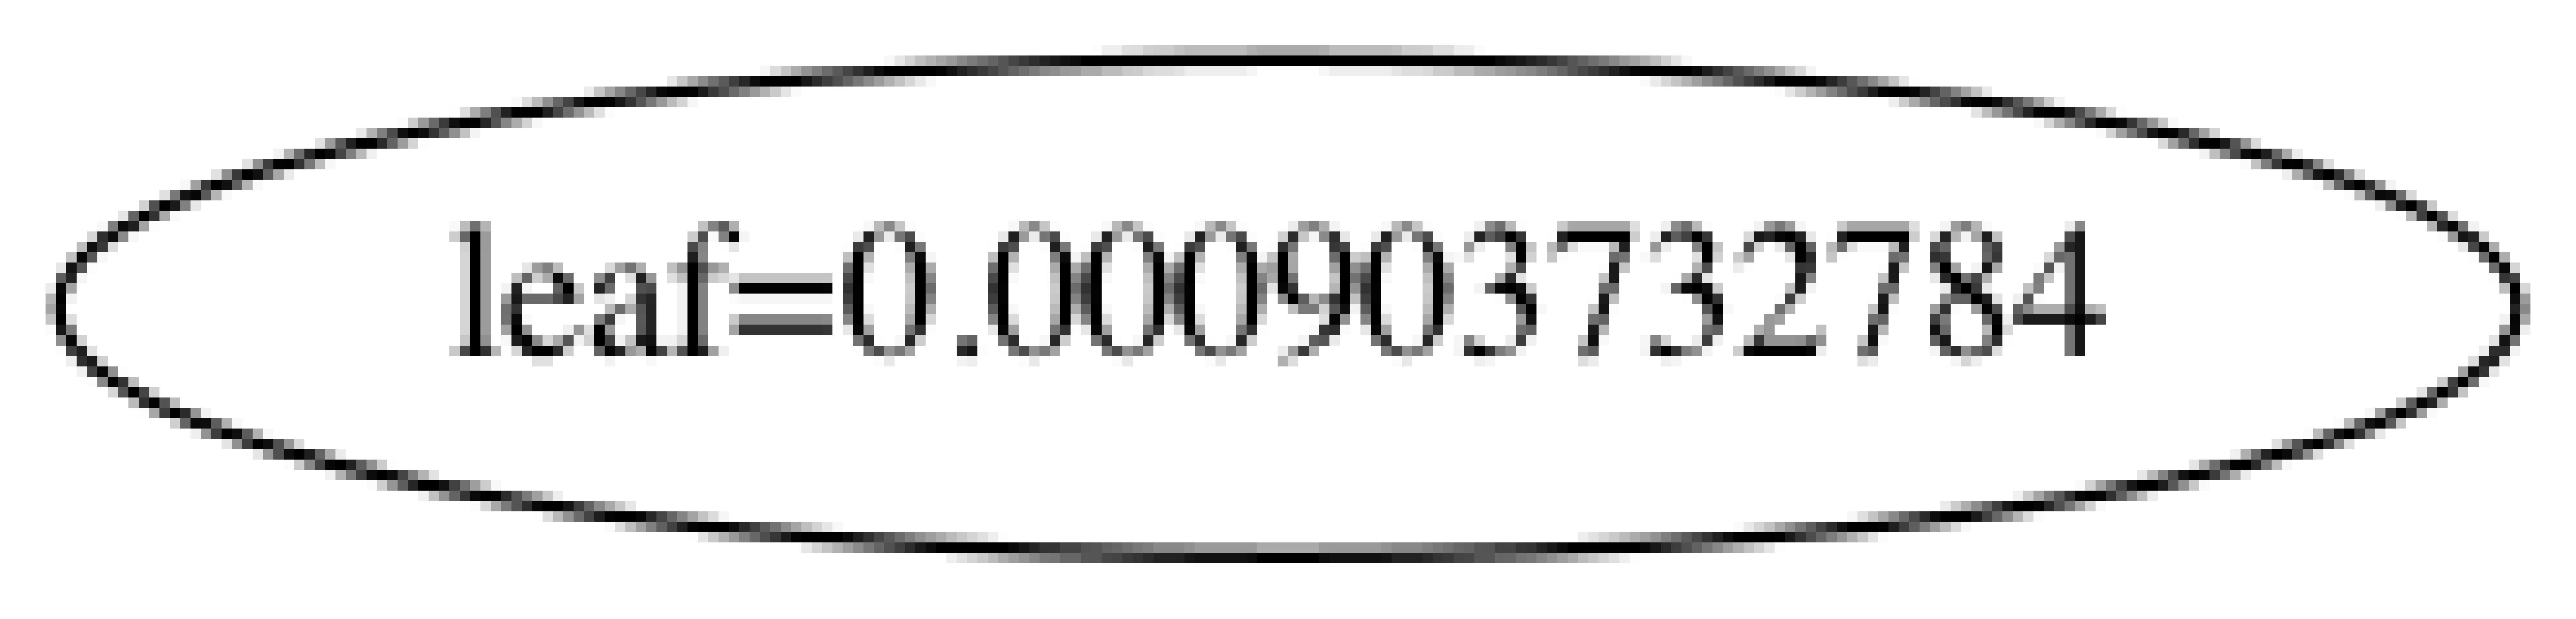

In [33]:
rcParams["figure.figsize"] = 80, 50
plot_tree(classifier)

### Conclusion

We feel that it is possible using Machine Learning, that we can forecast with better than 50/50 odds, whether the Range (our interpretation of volatility) for Bitcoin, can be predicted ahead of of time by at least 1 day into the future. This information could be valuable for MOVE based contracts trading.